# **Deep Learning based detection of hypoxic ischemic encephalopathy after cardiac arrest in CT images**

This work investigates a DenseNet based classification model of hypoxic ischemic encephalopathy (HIE) in patients after out-of hospital cardiac arrest (OHCA)
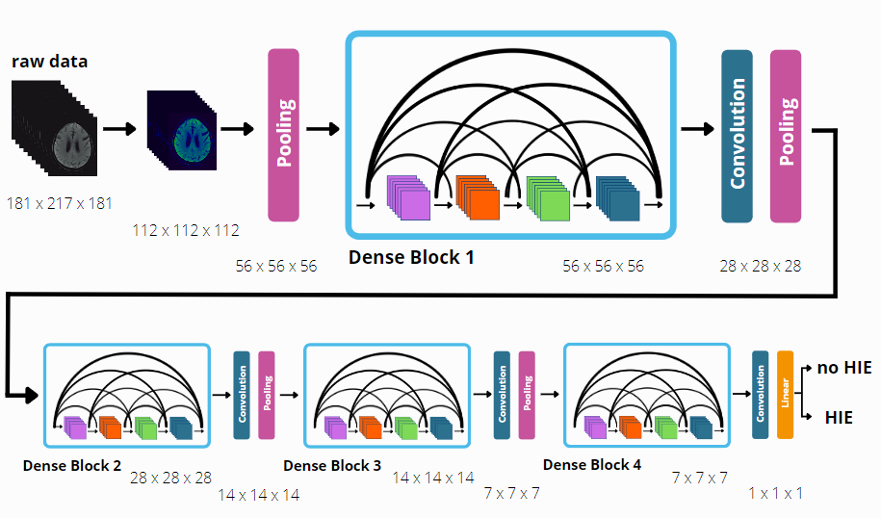



**Setup environment**

In [ ]:
!pip install Pillow==9.0.0
!pip install matplotlib==3.1.3
!python -c "import monai" ||pip install "monai[nibabel, skimage, pillow, tensorboard, gdown, ignite, torchvision, einops, itk, tqdm, lmdb, psutil]"
!pip install itkwidgets
!pip install itk-io
!pip install vit-pytorch


**Setup imports**

In [ ]:
#import logging
import os
import sys
import tempfile
import shutil
import nibabel as nib
import matplotlib.pyplot as plt
import torch
from torch.utils.tensorboard import SummaryWriter
from natsort import natsorted
from ipywidgets import interact, interactive, IntSlider, ToggleButton
import numpy as np
import matplotlib as mpl

import monai
from monai.networks.nets import DenseNet121, Classifier, EfficientNet, EfficientNetBN
from monai.apps import download_and_extract
from monai.config import print_config
from monai.utils import first
from monai.visualize import GradCAM,GradCAMpp
from monai.metrics import ConfusionMatrixMetric, get_confusion_matrix
from monai.data import CacheDataset, DataLoader, ImageDataset, ITKReader, PILReader, Dataset, partition_dataset_classes, partition_dataset
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay, roc_auc_score, balanced_accuracy_score
from monai.visualize import blend_images, matshow3d, plot_2d_or_3d_image
from monai.data import decollate_batch
from monai.metrics import ROCAUCMetric
from torch.utils.data import DataLoader 
from monai.transforms import Transform
from monai.transforms import (
    AddChannel,
    Compose,
    LoadImage,
    RandRotate90,
    AsChannelFirstd,
    ScaleIntensityd,
    Rotate90d,
    DivisiblePadd,
    Invertd,
    RandRotate,
    RandFlip,
    RandZoom,
    Lambda,
    Resize,
    GibbsNoise,
    Orientation,
    RandBiasField,
    RandGaussianNoise,
    RandAdjustContrast,
    Orientationd,
    EnsureChannelFirstd,
    ScaleIntensity,
    AsChannelFirst,
    AsChannelLast,
    Activations,
    AddChannel,
    AddChanneld,
    ToTensord,
    Resized,
    AsDiscrete,
    Spacingd,
    EnsureChannelFirst,
    RepeatChannel,
    RemoveRepeatedChannel,
    ScaleIntensityRanged,
    SplitChannel,
    SqueezeDim,
    ToTensor,
    CropForegroundd,
    Randomizable,
    LoadImaged,
    ToTensord,
    MaskIntensityd,
    Flip,
    MaskIntensity,
    ScaleIntensityd,
    EnsureType,
    EnsureTyped,
)
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pandas as pd
import seaborn as sns 
import itk
import matplotlib
from enum import Enum
import tensorboard
#from itkwidgets import view
from random import shuffle
from sklearn import metrics
import PIL

from glob import glob
import logging
from abc import ABC, abstractmethod
from typing import Any, Callable, Dict, Generator, Hashable, Iterable, List, Optional, Tuple
from monai.utils import first, set_determinism 
from monai.data.utils import partition_dataset_classes
from math import ceil
from tqdm.notebook import tqdm, trange
#from downloaddata import fetch_data as fdata
import matplotlib.pyplot as plt
!pip install -q itkwidgets

from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier 
from monai.transforms import Transform, AddChannel, AsChannelFirst
from monai.networks.utils import eval_mode, train_mode
from monai.data.utils import pad_list_data_collate
from monai.visualize import GradCAM, GradCAMpp, OcclusionSensitivity

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
print_config()

**Data Managment**

In [ ]:
#Load Test-Data 
labels_test = pd.read_csv (r'HIE_allTest_bet.csv',delimiter=';')
labels=labels_test["Label"].to_numpy()
orig_labels=labels
print(orig_labels)

images = sorted(glob(os.path.join('2D_BG_Test_bet/', "*.png")))
images=natsorted(images)
print(images)

data = [{"image": i, "label": l} for i, l in zip(images, labels)]
transforms = Compose([
    LoadImaged("image"),
    EnsureChannelFirstd("image"),
    ScaleIntensityd("image"),
    Resized(keys=["image"], spatial_size=(250, 300)),
    Rotate90d("image", k=3)
])

data_partition= partition_dataset_classes(data, labels.tolist(), shuffle=True, ratios=[0.8, 0.2])

test_ds = CacheDataset(data=data, transform=transforms)
test_loader = DataLoader(test_ds, batch_size=2, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())

batch_size = 4

ds = Dataset(data, transforms)
dl = DataLoader(
    ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    collate_fn=pad_list_data_collate,
    drop_last=False,
)

In [ ]:
#CM for TEST data

class Classes(Enum):
    no_HIE = 0
    HIE = 1

#device = torch.device("cuda")
device = torch.device("cpu")
model = monai.networks.nets.DenseNet121(spatial_dims=2, in_channels=4, out_channels=2)
model.load_state_dict(torch.load("HIE_2D_BG_bet.pth"))
model.to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
auc_metric = ROCAUCMetric()
#print(model)

orig_labels=np.array([])
prob_labels=np.array([])
pred_labels=np.array([])
with eval_mode(model):
    rand_data=test_ds
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for data in tqdm(dl):
        images, labels = data["image"].to(device), data["label"].to(device)
        with torch.cuda.amp.autocast() if True else nullcontext():
            outputs = model(images).detach()
        y_pred = torch.cat([y_pred, outputs], dim=0)

        y = torch.cat([y, labels], dim=0)
   
    test_labels = np.array(y.cpu())   
    y_pred = y_pred.argmax(dim=1)
    pred_labels=np.array(y_pred.cpu())

    for row, d in enumerate(rand_data):
        img = torch.as_tensor(d["image"])[None].to(device)
        val_outputs = model(img)
        prob = torch.nn.functional.softmax(val_outputs,dim=1)
        top_p, top_class = prob.topk(1, dim = 1)
        sigmoidScores = torch.sigmoid(val_outputs)
        sigma_vals=sigmoidScores.cpu().numpy().tolist()
        sigma_vals=np.array(sigma_vals).transpose()
        sigma_vals=sigma_vals[1]
        orig_val=(d['label'])
        pred_label = model(img).argmax(dim=1).item()
        pred_val=pred_label
        orig_labels=np.append(orig_labels,orig_val)
        pred_labels=np.append(pred_labels,pred_val)
        prob_labels=np.append(prob_labels,sigma_vals)


print(classification_report(
    y.cpu().numpy(),
    y_pred.cpu().numpy(),
    target_names=[d.name for d in Classes]))
    

cm = confusion_matrix(
        y.cpu().numpy(),
        y_pred.cpu().numpy(),
        normalize='true',
    )
disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=[a.name for a in Classes],
    )
_ = disp.plot(ax=plt.subplots(1, 1, facecolor='white')[1])





In [ ]:
#ROCAUC for TEST-Daten
print(prob_labels)
print(pred_labels)
print(orig_labels)
fpr, tpr, threshold = metrics.roc_curve(orig_labels, prob_labels,pos_label=1)
roc_auc = metrics.auc(fpr, tpr)

plt.clf()
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

---------
ID: A012_1
Orig: HIE
Pred: HIE
0 0
0 1
0 2
0 3
---------
ID: A013_1
Orig: no_HIE
Pred: no_HIE


The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


1 0
1 1
1 2
1 3
---------
ID: A034_1
Orig: HIE
Pred: no_HIE
2 0
2 1
2 2
2 3
---------
ID: A039_1
Orig: no_HIE
Pred: no_HIE
3 0
3 1
3 2
3 3
---------
ID: A042_1
Orig: HIE
Pred: HIE
4 0
4 1
4 2
4 3
---------
ID: A080_1
Orig: no_HIE
Pred: HIE
5 0
5 1
5 2
5 3
---------
ID: A081_1
Orig: HIE
Pred: HIE
6 0
6 1
6 2
6 3
---------
ID: A085_1
Orig: no_HIE
Pred: no_HIE
7 0
7 1
7 2
7 3
---------
ID: A088_1
Orig: HIE
Pred: no_HIE
8 0
8 1
8 2
8 3
---------
ID: A101_1
Orig: no_HIE
Pred: no_HIE
9 0
9 1
9 2
9 3
---------
ID: A102_1
Orig: no_HIE
Pred: no_HIE
10 0
10 1
10 2
10 3
---------
ID: A112_1
Orig: no_HIE
Pred: no_HIE
11 0
11 1
11 2
11 3
---------
ID: A124_1
Orig: HIE
Pred: HIE
12 0
12 1
12 2
12 3
---------
ID: A153_1
Orig: HIE
Pred: no_HIE
13 0
13 1
13 2
13 3
---------
ID: A171_1
Orig: HIE
Pred: no_HIE
14 0
14 1
14 2
14 3
---------
ID: A183_1
Orig: HIE
Pred: no_HIE
15 0
15 1
15 2
15 3
---------
ID: B001_1
Orig: HIE
Pred: no_HIE
16 0
16 1
16 2
16 3
---------
ID: B019_1
Orig: no_HIE
Pred: HIE
17 0
1

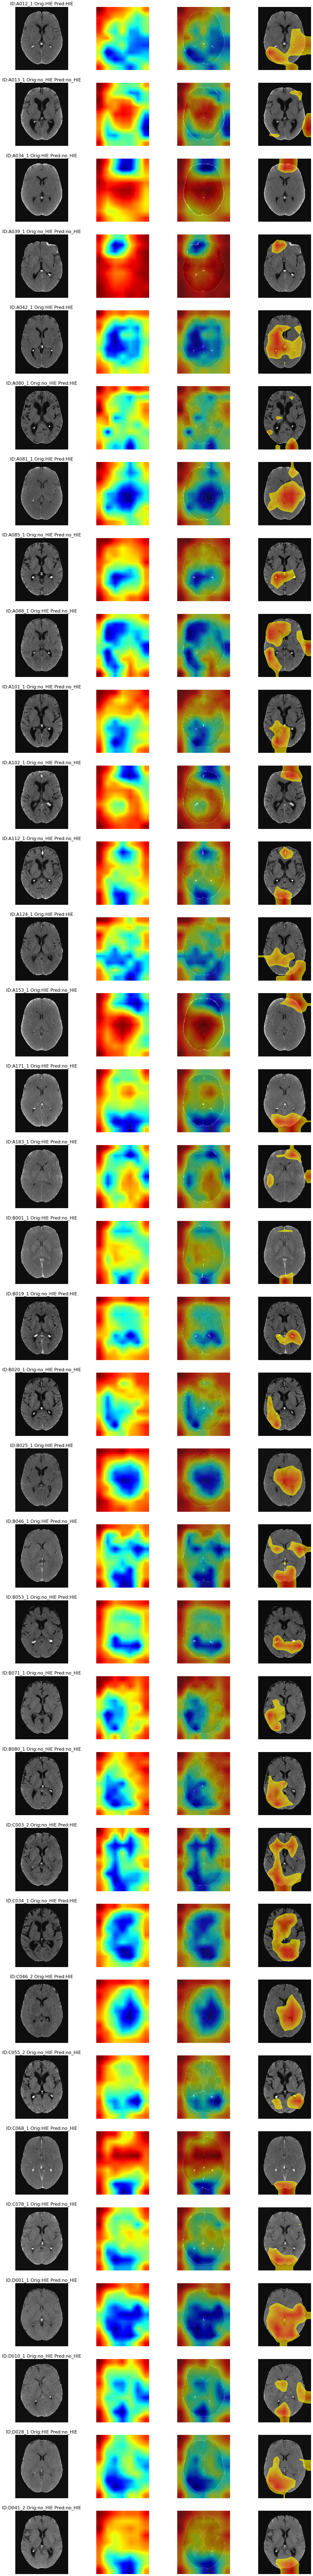

In [ ]:
#Übersicht mit TEST-Daten

from PIL import Image

# for name, _ in model.named_modules(): print(name)
target_layer = "class_layers.relu"
gradcam = GradCAM(model, target_layers=target_layer)
gradcampp = GradCAMpp(model, target_layers=target_layer)
#occ_sens = OcclusionSensitivity(model, mask_size=50, n_batch=batch_size, stride=divisible_factor)

images_names = sorted(glob(os.path.join('/content/drive/MyDrive/Charite_HIE_enhanced/2D_BG_Test_bet/', "*.png")))
images_names=natsorted(images_names)

with eval_mode(model):
    num_examples = len(ds)
    num_cols=4
    #rand_data = np.random.choice(ds, replace=False, size=num_examples)
    rand_data=ds
    subplot_shape = [num_examples, num_cols]
    figsize = [i * 5 for i in subplot_shape][::-1]
    fig, axes = plt.subplots(*subplot_shape, figsize=figsize, facecolor='white')


    #rand_data=ds
    for row, d in enumerate(rand_data):
        im_orig=images_names[row]
        imageo = Image.open('{}'.format(im_orig))
        imageo = imageo.resize((250, 300), Image.ANTIALIAS).convert('L')
        img = torch.as_tensor(d["image"])[None].to(device)
        img_np=img.cpu().numpy()
        img_np=img_np[0][0]
        #print(img_np)
        minval=np.percentile(img_np,0)
        maxval=np.percentile(img_np,100)
        pixvals=np.clip(img_np,minval,maxval)
        pixvals = ((pixvals-minval) /(maxval-minval))*255
        #pixvals = img_np
        #print(pixvals)
        #plt.imshow(img_np, cmap="gray")

        filename=d['image_meta_dict']['filename_or_obj']
        name_short = filename.replace("/content/drive/MyDrive/Charite_HIE_enhanced/2D_BG_Test_bet/", "")
        name_short = name_short.replace("_75.png", "")
        
      
        label = d["label"]
        orig_label=Classes(d['label']).name
        pred_label = model(img).argmax(dim=1).item()
        pred_name=Classes(pred_label).name

        print('---------')
        print('ID:',name_short)
        print('Orig:',orig_label)
        print('Pred:',pred_name)

        

        with train_mode(model):
            res_cam_pp = gradcampp(x=img, class_idx=pred_label)[0]
            

        # Occlusion sensitivity images
        #occ_map = occ_sens(img)[0][0]
        #occ_np=np.array(occ_map) 


        gc_img_np=res_cam_pp
        gc_img_np=np.array(gc_img_np.cpu())
        gc_img_np=gc_img_np[0]
        #print(len(gc_img_np),len(gc_img_np[0]))
        #print(len(img_np),len(img_np[0]))
           

        for col in range(num_cols):
            ax = axes[row, col]
            print(row,col)

            if col==0:
              #ax.imshow(pixvals, cmap="gray")
              
              ax.imshow(imageo, cmap='gray')
              ax.set_title(f"ID:"+ name_short+ " Orig:"+ orig_label+ " Pred:"+ pred_name,fontsize=16)
              ax.axis('off')

            if col==1:
              ax.imshow(gc_img_np,cmap='jet')

              ax.axis('off') 

            if col==2:
              ax.imshow(pixvals, cmap="gray",alpha=1)
              ax.imshow(gc_img_np, interpolation='none', cmap='jet',alpha=0.6)
              ax.axis('off') 

            if col==3:

              ax.imshow(imageo, cmap="gray",alpha=1)
              cmap = mpl.cm.get_cmap("autumn")
              cmap.set_over(color='black',alpha = 0.02)
              ax.imshow(gc_img_np,cmap=cmap,vmax=np.max(gc_img_np)*0.3,alpha=0.66)
              #ax.imshow(gc_img_np, interpolation='none', cmap='autmn',alpha=0.7)
              ax.axis('off')

